IENLP Project : Natural Language Processing Using Scikit-Learn
===========

This goal of this notebook is to build a system, based on *text classification* that is able to accurately recommend a conference given a title of conference paper.

#### The main objectives of the project are as follows:
- Design and implement a system to recommend a conference to a researcher for a given title
- Perform the task stated above by using the provided conference proceedings trianing data
- Use a few classification algorithms to achieve the task of classificaiton
- Evaluate the system by using cross-validation approach
- Test the system with the provided test dataset and report results

#### Import Relevant Libraries
In this project the following libraries will be used:
- nltk: natural language processing library 
- os: handling file locations
- re: handling regular expressions
- string: handling various String manipulations
- pandas: representing and handling data
- numpy: handling numerical data
- seaborn: visualizing data
- matplotlib: visualizing data

In [1]:
import nltk # nltk library for natural language processing

from nltk.corpus import stopwords # stopwords that can be removed from text
from nltk import word_tokenize


import os # os library to handle file locations
import re # regular expressions
import string

# Data processing
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Uncomment the following if necessary:
#nltk.download("stopwords")

## Part 1: Data Exploration

### Description of the Train Dataset
The data set contains the following informaiton:
- Conference Name: The name of the conference where which the given title takes place
- Title: The title of the conference paper which takes place at the given conference

Additional Information about the Dataset:
- 5 Unique conference names
- 21,643 unique titles, and data points (no repeating titles)
- ISCAS is the conference with most titles

#### Organize data into pandas dataframes:

In [2]:
train_df = pd.read_csv('datasets/DBLPTrainset.txt',sep='\t',names=['Index', 'Conference Name', 'Title'],index_col='Index')
train_df['Length of Title'] = train_df['Title'].apply(len)

test_df = pd.read_csv('datasets/DBLPTestGroundTruth.txt',sep='\t',names=['Index','Conference Name'],index_col='Index')
_test_df = pd.read_csv('datasets/DBLPTestset.txt',sep='\t',names=['Index','Title'],index_col='Index')


test_df['Title'] = _test_df['Title']

#### Exoplore the training data set
Note: the test data set is similar to the training dataset and thus its exploration is omitted

In [3]:
train_df.head(3)

,Conference Name,Title,Length of Title
Index,,,
0,ISCAS,Scalable Serial-parallel Multiplier over GF(2m...,102
1,SIGGRAPH,Plenoptic sampling.,19
2,ISCAS,Sensitivity and uniformity of a 0.18micrometer...,82


In [4]:
train_df.drop('Length of Title',axis=1).describe()

,Conference Name,Title
count,21643,21643
unique,5,21497
top,ISCAS,Front Matter.
freq,7514,17


In [5]:
train_df.describe()

,Length of Title
count,21643.000000
mean,67.722682
std,22.487214
min,5.000000
25%,52.000000
50%,67.000000
75%,83.000000
max,214.000000


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21643 entries, 0 to 21642
Data columns (total 3 columns):
Conference Name    21643 non-null object
Title              21643 non-null object
Length of Title    21643 non-null int64
dtypes: int64(1), object(2)
memory usage: 676.3+ KB


### Visualizing the Dataset

Let us now visualize the dataset in order to acquire familiarity.

We will be looking at the following:
 - Frequency of Conference Names 
 - Length of Titles Per Conference

#### Frequency of Conference Names

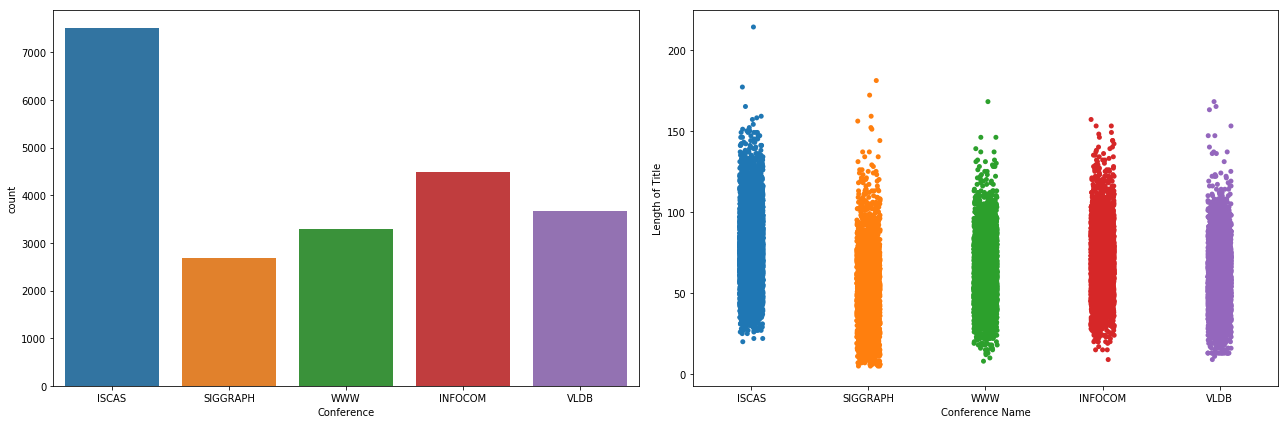

In [7]:
fig, ax = plt.subplots(1,2, figsize=(18,6))

sns.countplot(train_df['Conference Name'],ax=ax[0])
ax[0].set(xlabel="Conference")

sns.stripplot(x="Conference Name", y="Length of Title", jitter=True, data=train_df,ax=ax[1])

fig.tight_layout()

The plot on the left shows that the titles are distributed similarly across the different conferences, with the exception of ISCAS. Furthermore, the length of titles per conference is also distributed similarly. It seems that there isn't a clear way to visually identify a conference based on the length of a given title.

#### Note

The plot above shows that the majority of the titles belog to the ISCAS conference. This might perhaps raise a problem because conventional algorithms are known to be often biased towards the major catagory, without taking the general distribution into account.

#### Distribution of Length Titles

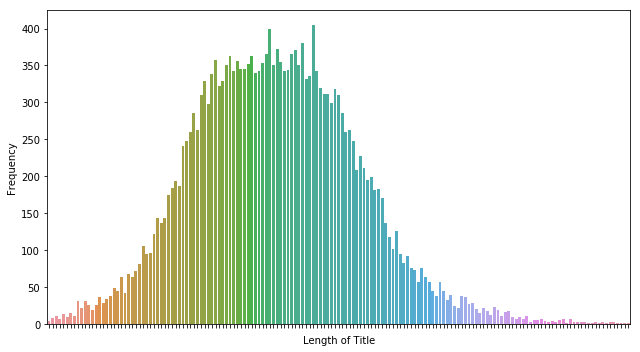

In [9]:
fig, ax = plt.subplots(1, figsize=(9,5))
sns.countplot(train_df['Length of Title'],ax=ax)
ax.set(xlabel='Length of Title',ylabel='Frequency')
ax.xaxis.set_major_formatter(plt.NullFormatter())
fig.tight_layout()

The length of titles in the given training set seem to be following a normal distribution, with a slight skew to the left (positive skew)

## Part 2: Data Preprocessing

Now that the data is neatly organized into pandas dataframes we can proceed with further processing. The main goal of this section is to prepare the corpus for text classification algorithms.

The tasks at hand are the following:
- Clean: remove unwanted textual data
- Toekenize: perform text toekenization
- Vectorize: perform text vectorization by using bag of words model
- Determine term frequency: weigh importance of words in their titles
- Determine inverse data frequencey: Weigh importance of a word compared to other titles in the corpus

### Tokenization

We will now define a tokenization function that suits well to our purpose of classifying titles to their corresponding titles. In order to do that we will take the following into account:

- Remove characters that are not part of the English alphabet
- Remove punctuation
- Convert all text to lowercase
- Remove English stopwords

Some of these might not be relevat to the titles because they might be technicall and hardly contain factors listed above.

In [10]:
def custom_tokenizer(text):
    
    reg_ex = re.compile('[a-zA-Z0-9]+')
    
    no_punc = [char for char in text if char not in string.punctuation]
    
    no_punc = ''.join(no_punc)
    
    no_punc = [word.lower() for word in no_punc.split() if word.lower() not in stopwords.words("english")]
    
    return list(filter(lambda word: reg_ex.match(word),no_punc))

The function above can be applied to a title and it will convert it into a list of words without unnecessary words. An example is shown below:

In [11]:
train_df['Title'].head(2).apply(custom_tokenizer)

Index
0    [scalable, serialparallel, multiplier, gf2m, h...
1                                [plenoptic, sampling]
Name: Title, dtype: object

### Vectorization

#### Bag of Words Model

This model does the following:
- Count the number of occurences of a word in each article
- Weigh the counts according the their frequency of occurence
- Normalize to unit length

We will be using a feature extraction method, from sklearn, called CountVectorizer(). It will perform the task as we desire.

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

bow_model = CountVectorizer(analyzer=custom_tokenizer)
bow_model.fit(train_df['Title'])

CountVectorizer(analyzer=<function custom_tokenizer at 0x000002096ED3EB70>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=None,
        stop_words=None, strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabulary=None)

Now that we fitted the trianing data into a bag of words model, we can look into the amount of vocabulary of the bag. Meaning, we can look how many words exist in our bag of words:

In [15]:
print("There are " + str(len(bow_model.vocabulary_)) + 
      " vocabulary words in the bag of words model.")

There are 19773 vocabulary words in the bag of words model.


The following task, once we have the bag of words, is to transform it into some sort of mathematical representation. This is done because the algorithms are suited for mathematical data rather than textual. 

We can convert the bag of words model into a sparse matrix. This very large sparse matrix will represent our bag and we will be using it in upcoming sections.

In [16]:
bow_conference = bow_model.transform(train_df['Title'])

#### Note

It is worth mentioning that this matrix is very sparse, meaning that it is mostly zero's; only 3.4% of it is non zero. Below, some extra information about the sparse matrix is shown:

In [18]:
print('Shape of transformed matrix is: ', bow_conference.shape)
print('Number of non zero occurences in the matrix is: ', bow_conference.nnz)


non_zero_percentage = (100.0 * bow_conference.nnz / (bow_conference.shape[0] * bow_conference.shape[1]))
print("The percentage of non zero occurences is: ", round((non_zero_percentage*100),1),"%")



Shape of transformed matrix is:  (21643, 19773)
Number of non zero occurences in the matrix is:  146831
The percentage of non zero occurences is:  3.4 %


#### Repeat the steps above for the test set

It is important to use the same model for the test set as the training set, otherwise problems might arise as the dimentionality between the datasets mismatch. This is because the variable being tested, in this case the name of the conference, is a String and it needs a feature vector with the same number of dimentsions as X_test. Thus, the same bag of words model (bow_model) ought to be used.

In [19]:
bow_conference_test = bow_model.transform(test_df['Title'])

### TF-IDF Model

This model transforms the word count, done with CountVectorizre(), into term frequency and inverse document frequency.

#### Term Frequency (TF)
This parameter will determine the frequency of the word in each title of the collection and weighs it accordingly. Each title will have its own term frequency. Mathematically, the term frequency is defined as follows:

$$tf_{i,j}= \frac{n_{i,j}}{\sum_{k}n_{i,j}}$$

#### Inverse Data Frequency (IDF)
This parameter will determine the weight of a word with respect to the collection of titles in the entire dataset. For example, the words that are rare will have a high IDF score. Mathematically, the IDF is definded as follows:

$$idf_{w}= \log\frac{N}{df_{t}}$$

Combining the two concepts above in a ratio, a TF-IDF score can be determinned:

$$w_{i,j}= tf_{i,j}\cdot\log\frac{N}{df_{t}}$$

Fortunately sklearn's feature extraction modules contain a method that will perform the mathematical manipullations above rather easily and we will be using it for our task.

In [21]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_model = TfidfTransformer()
tfidf_model.fit(bow_conference)

conference_bow_tfidf = tfidf_model.transform(bow_conference)

# Test Set:

tfidf_model.fit(bow_conference_test)
conference_bow_tfidf_test = tfidf_model.transform(bow_conference_test)

## Part 3: Classification

Now that the data is processed, it is ready for a classification algorithm. We will start the classification by using the Naive Bayes approach. Afterwards we will consider other classifiers and attempt to come up with a classifier that will have high accuracy.

Note that we will be using sklearn's implementation of the algorithms for our task.

In [23]:
from sklearn.naive_bayes import MultinomialNB

The first task is to fit the Naive Bayes model onto the data we prepared. Then, we need to use the fitted model to test it on title it has never seen before so that the accuracy of the model can be quantified.

In [24]:
nb_classifier = MultinomialNB()
nb_classifier.fit(conference_bow_tfidf, train_df['Conference Name'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

#### Prediction:

In [25]:
nb_predictions = nb_classifier.predict(
    conference_bow_tfidf_test)

We can now evaluate the model and determine its precision. We will be doing this by making use of a classification report from sklearn.

In [27]:
from sklearn.metrics import classification_report
print (classification_report(test_df['Conference Name'], nb_predictions))

             precision    recall  f1-score   support

    INFOCOM       0.76      0.80      0.78       502
      ISCAS       0.92      0.96      0.94      2043
   SIGGRAPH       0.95      0.56      0.70       186
       VLDB       0.60      0.72      0.65       219
        WWW       0.83      0.68      0.75       423

avg / total       0.87      0.86      0.86      3373



Although this model accurately predicts 87% of the titles to the right conference names, it is worth investigating other models to determine if the accuracy can be increased. In order to investigate other classifiers we need to take advantage of sklearn's several modules and pandas dataframes. We need to do this because the semi-mannual data preparation performed in this notebook thus far is time consuming. 

First, we need to combine all the data into one dataframe including all the test set and train set. We do that in order to use sklearn's test_train splitter such that all the data manipulation is done in one step. Furthermore, we will be using factorization methods from pandas to represent the conferences as integers to make it easier for the classifiers.

In [41]:
df1 = pd.read_csv('datasets/DBLPTrainset.txt',sep='\t',names=['Conference Name', 'Title'])

df2 = pd.read_csv('datasets/DBLPTestGroundTruth.txt',sep='\t',names=['Conference Name'])
_df2 = pd.read_csv('datasets/DBLPTestset.txt',sep='\t',names=['Title'])
df2['Title'] = _df2['Title'] 

frames = [df1, df2]
main_df = pd.concat(frames)


main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25016 entries, 0 to 3372
Data columns (total 2 columns):
Conference Name    25016 non-null object
Title              25016 non-null object
dtypes: object(2)
memory usage: 586.3+ KB


In [43]:
main_df['con_id'] = main_df['Conference Name'].factorize()[0]
main_df.head()

,Conference Name,Title,con_id
0,ISCAS,Scalable Serial-parallel Multiplier over GF(2m...,0
1,SIGGRAPH,Plenoptic sampling.,1
2,ISCAS,Sensitivity and uniformity of a 0.18micrometer...,0
3,WWW,A survey of web archive search architectures.,2
4,ISCAS,Understanding dynamic behavior of mm-wave CML ...,0


#### Process the text

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()

features = tfidf.fit_transform(main_df.Title).toarray()
labels = main_df.con_id

## Estimating Accuracy of Different Models

Let us now roughly examine different classifier models by using the cross_val_score() method from sklearn. This method would allow us to estimate the accuracy on the given dataset by splitting the data, fitting it to the given model and calculating the accuracy score a given number of consecutive times. It is important to note that the results given by this method are rough, meaning that they can be made better by manually adjusting different parameters.

The following code will roughly determine the accuracy of the following classifier models:
- Logistic regression
- Random forest classifier
- Linear support vector classification
- SGDClassifier

In [48]:
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

In [46]:
models = [LogisticRegression(random_state=0),
    RandomForestClassifier(),
    LinearSVC(),
    SGDClassifier()
]

Note: The code below might take some time to run.

In [50]:
CV = 5
models_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features,
                        labels, scoring='accuracy',cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

models_df = pd.DataFrame(entries,columns=['Model','fold_idx','Accuracy'])

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\User\Anaconda3\lib\site-p

### Visualizing Accuracies of Different Models

Now that we have roughly estimated the accuracy of different classifiers, we can now visualize the accuracy:

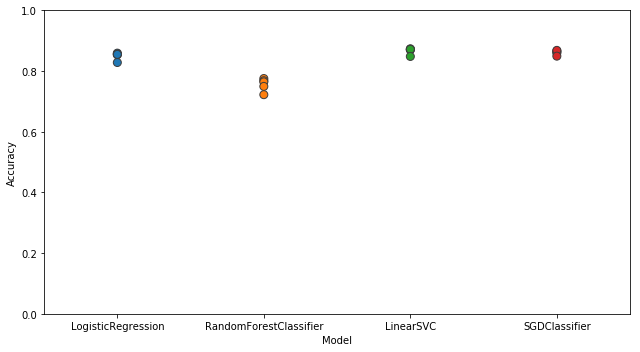

In [69]:
fig, ax = plt.subplots(1, figsize=(9,5))

#sns.boxplot(x='Model',y='Accuracy',data=models_df)
sns.stripplot(x='Model',y='Accuracy',ax=ax,
            data=models_df,size=8,
            jitter=False,edgecolor="gray",linewidth=1)

ax.set_ylim([0,1])
plt.tight_layout()
plt.show()

In [72]:
models_df.groupby('Model').Accuracy.mean()

Model
LinearSVC                 0.866883
LogisticRegression        0.850493
RandomForestClassifier    0.755951
SGDClassifier             0.861328
Name: Accuracy, dtype: float64

### Testing Best Classifier

Now that we know linear support vector classifier is the best, we can manually test it to see how well it predicts given titles.

In [73]:
svc_classifier = LinearSVC()
svc_classifier.fit(conference_bow_tfidf, train_df['Conference Name'])

svc_predictions = svc_classifier.predict(
    conference_bow_tfidf_test)

print (classification_report(test_df['Conference Name'], svc_predictions))

             precision    recall  f1-score   support

    INFOCOM       0.73      0.77      0.75       502
      ISCAS       0.95      0.90      0.93      2043
   SIGGRAPH       0.70      0.81      0.75       186
       VLDB       0.54      0.77      0.63       219
        WWW       0.79      0.73      0.76       423

avg / total       0.86      0.85      0.85      3373



It seems that the first classifier used in this notebook, MultinomialNB(), performed slightly better than LinearSVC() at an accuracy of 87%. We will not visualize the best classifier and see how many of the titles were classified correctly and incorrectly, we will be doing this by using a heatmap:

### Visualizing the Best Classifier

Before visualizing the results, we need to perform some data manipulations using pandas and python dictionaries:

In [82]:
df = main_df
df.rename(columns={'Conference Name':'con'},inplace=True)
category_id_df = df[['con', 'con_id']].drop_duplicates().sort_values('con_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['con_id', 'con']].values)

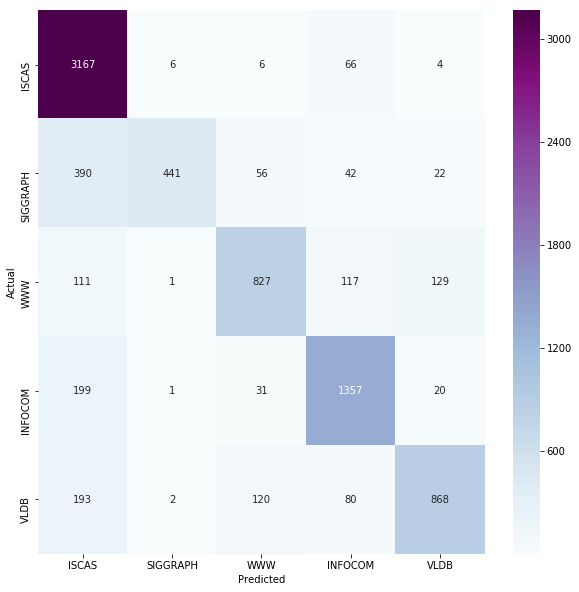

In [87]:
from sklearn.model_selection import train_test_split

model = MultinomialNB()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, main_df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.con.values,
            yticklabels=category_id_df.con.values,
           cmap="BuPu")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Further Improvements

- ISCAS: High accuracy problem, due to high occurence fix XXXXXXXXXX